Feature engineering is often considered more of an art than a science. It's the process of using domain knowledge and creativity to transform raw data or create new features from existing ones, aiming to make machine learning algorithms work better. Good feature engineering can significantly boost model performance by making underlying patterns more apparent to the model.

## Feature Engineering Techniques

This document covers several key feature engineering techniques:

* **Interaction & Polynomial Features:** Creating features representing interactions between variables or polynomial terms using manual calculations or `PolynomialFeatures`.
* **Transformations:** Applying functions like `log` or `sqrt` to handle skewed data or stabilize variance. Mentions `Box-Cox`.
* **Binning/Discretization:** Grouping continuous data into discrete bins using `KBinsDiscretizer`, `pd.cut`, or `pd.qcut`.
* **Date/Time Features:** Extracting useful components (year, month, day of week, hour, etc.) from datetime columns using the `Pandas` `.dt` accessor.
* **Domain-Specific Features:** Discusses the concept of creating features based on specific knowledge of the problem domain.
* **Considerations:** Highlights the iterative nature and importance of integrating these steps into pipelines.

---

Feature engineering is a powerful way to improve your models by providing them with better, more informative input.

--- Original Sample Data ---
      Length     Width    Height  Temperature           Timestamp  SkewedValue
0   4.745401  1.157146  1.784063    25.227859 2024-01-01 15:34:00   221.967583
1  10.507143  4.182052  0.668280    21.741998 2024-01-02 06:37:00    61.817526
2   8.319939  2.571780  0.823257    35.719720 2024-01-03 20:46:00    97.793303
3   6.986585  3.542853  2.297108    28.169595 2024-01-04 10:33:00    33.487342
4   2.560186  5.537832  1.712858    14.874287 2024-01-05 19:16:00    21.840416
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Length       100 non-null    float64       
 1   Width        100 non-null    float64       
 2   Height       100 non-null    float64       
 3   Temperature  100 non-null    float64       
 4   Timestamp    100 non-null    datetime64[ns]
 5   SkewedValue  100 non-null    float64       
dt

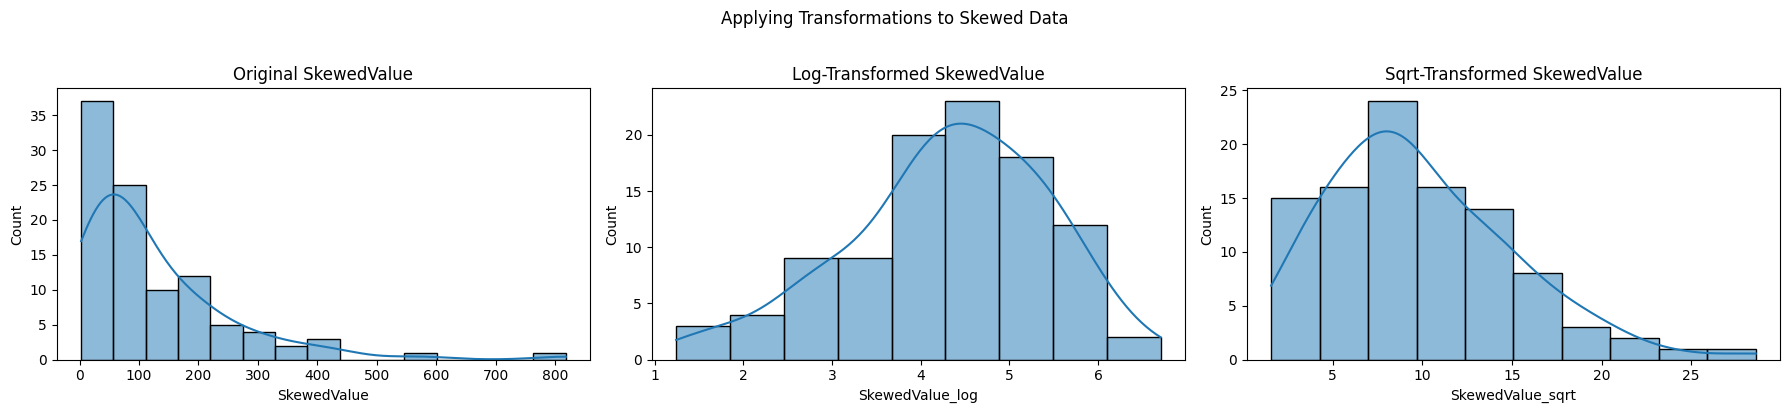

Transformations can make distributions more symmetric.
------------------------------
--- Binning / Discretization ---

--- a) KBinsDiscretizer ---
Temperature after Quantile Binning (KBinsDiscretizer):
    Temperature  Temperature_bin_kbd
0    25.227859                  1.0
1    21.741998                  0.0
2    35.719720                  3.0
3    28.169595                  2.0
4    14.874287                  0.0
5    25.932272                  2.0
6    21.691068                  0.0
7    29.262167                  3.0
8    21.037396                  0.0
9    24.426318                  1.0
Bin edges: [ 8.79 21.97 25.42 28.77 35.72]

--- b) pd.cut ---
Temperature after Equal-Width Binning (pd.cut):
    Temperature Temperature_bin_cut
0    25.227859              Medium
1    21.741998              Medium
2    35.719720                 Hot
3    28.169595                 Hot
4    14.874287                Cold
5    25.932272              Medium
6    21.691068              Medium
7    29.2

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
# Optional: for Box-Cox transformation
# from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Goal of Feature Engineering ---
# - Create features that better represent the underlying problem to the model.
# - Make patterns more accessible for algorithms (e.g., linearizing relationships).
# - Incorporate domain knowledge into the feature set.
# - Improve model accuracy, robustness, and sometimes interpretability.

# --- 2. Create Sample Data ---
np.random.seed(42)
df = pd.DataFrame({
    'Length': np.random.rand(100) * 10 + 1,
    'Width': np.random.rand(100) * 5 + 1,
    'Height': np.random.rand(100) * 2 + 0.5,
    'Temperature': np.random.normal(25, 5, 100),
    'Timestamp': pd.to_datetime(pd.date_range('2024-01-01', periods=100, freq='D')) + pd.to_timedelta(np.random.randint(0, 1440, 100), unit='m'),
    'SkewedValue': np.random.exponential(scale=100, size=100) + 1 # Positive skewed data
})

print("--- Original Sample Data ---")
print(df.head())
df.info()
print("-" * 30)


# --- 3. Technique 1: Interaction Features & Polynomial Features ---
# Combining features to capture interactions or non-linear relationships.

print("--- Interaction & Polynomial Features ---")
# a) Manual Interaction: Create features based on domain knowledge or intuition.
df['Area'] = df['Length'] * df['Width']
df['Volume'] = df['Length'] * df['Width'] * df['Height']
print("Data with manually created 'Area' and 'Volume':\n", df[['Length', 'Width', 'Height', 'Area', 'Volume']].head())
print("-" * 20)

# b) PolynomialFeatures (Scikit-learn)
# Automatically generates polynomial terms (e.g., X^2, X^3) and interaction terms (e.g., X1*X2).
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
# Select columns to generate features from
features_to_transform = ['Length', 'Width']
poly_features = poly.fit_transform(df[features_to_transform])

# Get feature names
poly_feature_names = poly.get_feature_names_out(features_to_transform)
print(f"\nPolynomial Feature Names (degree=2): {poly_feature_names}")
# Output includes: Length, Width, Length^2, Length*Width, Width^2

# Create DataFrame for the new features
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
print("Generated Polynomial Features (first 5 rows):\n", poly_df.head())

# Can merge back if needed: df = pd.concat([df, poly_df], axis=1)
# Be mindful of high dimensionality created by high degrees.
print("-" * 30)


# --- 4. Technique 2: Transformations ---
# Applying mathematical functions to handle skewness, stabilize variance, or linearize relationships.

print("--- Transformations (Handling Skewness) ---")
print("Original SkewedValue description:\n", df['SkewedValue'].describe())

# Visualize original skewed distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['SkewedValue'], kde=True, ax=axes[0]).set_title('Original SkewedValue')

# a) Log Transformation (Common for right-skewed data)
# Use np.log1p (log(1+x)) to handle potential zero values gracefully.
df['SkewedValue_log'] = np.log1p(df['SkewedValue'])
sns.histplot(df['SkewedValue_log'], kde=True, ax=axes[1]).set_title('Log-Transformed SkewedValue')
print("\nDescription after Log Transform:\n", df['SkewedValue_log'].describe())

# b) Square Root Transformation (Also for right-skewed, less aggressive than log)
df['SkewedValue_sqrt'] = np.sqrt(df['SkewedValue'])
sns.histplot(df['SkewedValue_sqrt'], kde=True, ax=axes[2]).set_title('Sqrt-Transformed SkewedValue')
print("\nDescription after Sqrt Transform:\n", df['SkewedValue_sqrt'].describe())

# c) Box-Cox Transformation (More general, finds optimal power transformation)
# Requires positive data. Available in scipy.stats.
# from scipy.stats import boxcox
# try:
#     df['SkewedValue_boxcox'], fitted_lambda = boxcox(df['SkewedValue'])
#     print(f"\nBox-Cox Transformation applied (lambda={fitted_lambda:.2f})")
#     print("Description after Box-Cox:\n", df['SkewedValue_boxcox'].describe())
#     # sns.histplot(df['SkewedValue_boxcox'], kde=True, ax=axes[...]).set_title('Box-Cox Transformed')
# except ValueError as e:
#     print(f"\nBox-Cox failed (requires positive data): {e}")

plt.suptitle("Applying Transformations to Skewed Data", y=1.02)
plt.tight_layout()
plt.show()
print("Transformations can make distributions more symmetric.")
print("-" * 30)


# --- 5. Technique 3: Binning / Discretization ---
# Grouping continuous numerical features into discrete bins.

print("--- Binning / Discretization ---")
# Useful for capturing non-linear effects in linear models or simplifying features.

# a) Using KBinsDiscretizer (Scikit-learn)
print("\n--- a) KBinsDiscretizer ---")
# Bin 'Temperature' into 4 bins
n_bins = 4
# encode: 'ordinal' (0, 1, 2...), 'onehot', 'onehot-dense'
# strategy: 'uniform' (equal width bins), 'quantile' (equal frequency bins), 'kmeans'
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile', subsample=None)
df['Temperature_bin_kbd'] = kbd.fit_transform(df[['Temperature']])

print("Temperature after Quantile Binning (KBinsDiscretizer):\n", df[['Temperature', 'Temperature_bin_kbd']].head(10))
print("Bin edges:", kbd.bin_edges_[0].round(2))

# b) Using pd.cut (Fixed width bins or specified edges)
print("\n--- b) pd.cut ---")
# Create 3 bins of equal width for Temperature
df['Temperature_bin_cut'] = pd.cut(df['Temperature'], bins=3, labels=['Cold', 'Medium', 'Hot']) # Assign labels
print("Temperature after Equal-Width Binning (pd.cut):\n", df[['Temperature', 'Temperature_bin_cut']].head(10))
print("\nValue counts for pd.cut bins:\n", df['Temperature_bin_cut'].value_counts())

# c) Using pd.qcut (Quantile-based bins - equal frequency)
print("\n--- c) pd.qcut ---")
# Create 4 quantile-based bins for Temperature
df['Temperature_bin_qcut'] = pd.qcut(df['Temperature'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
print("Temperature after Quantile Binning (pd.qcut):\n", df[['Temperature', 'Temperature_bin_qcut']].head(10))
print("\nValue counts for pd.qcut bins:\n", df['Temperature_bin_qcut'].value_counts()) # Counts should be roughly equal
print("-" * 30)


# --- 6. Technique 4: Date/Time Features ---
# Extracting meaningful components from datetime objects.

print("--- Date/Time Feature Engineering ---")
print("Original Timestamp column:\n", df['Timestamp'].head())

# Use the .dt accessor on the datetime Series
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek # Monday=0, Sunday=6
df['DayName'] = df['Timestamp'].dt.day_name()
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int) # Saturday=5, Sunday=6
df['TimeOfDay'] = pd.cut(df['Hour'], bins=[-1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Calculate time differences (e.g., time since first event)
# df['TimeSinceStart'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds() / 3600 # Example: hours since start

print("\nDataFrame with extracted Date/Time features (first 5 rows):\n",
      df[['Timestamp', 'Year', 'Month', 'DayName', 'Hour', 'IsWeekend', 'TimeOfDay']].head())
print("-" * 30)


# --- 7. Technique 5: Domain-Specific Features ---
# Creating features based on understanding the specific problem or data source.
# This is highly context-dependent and often requires creativity.

print("--- Domain-Specific Features (Conceptual) ---")
print("- Example (E-commerce): Calculate 'PurchaseFrequency' for users, 'DaysSinceLastPurchase'.")
print("- Example (Text): Calculate 'WordCount', 'AvgSentenceLength', 'SentimentScore'.")
print("- Example (Finance): Calculate 'MovingAveragePrice', 'Volatility'.")
print("- Example (Geospatial): Calculate 'DistanceToNearestStore', 'PopulationDensity'.")
print("Requires understanding the problem and data source.")
print("-" * 30)


# --- 8. Final Considerations ---
print("--- Final Considerations ---")
print("- Feature engineering is often iterative: create features, test model, analyze, refine.")
print("- Avoid creating features that leak information from the target variable (especially if using target encoding).")
print("- Be mindful of increasing dimensionality (e.g., with PolynomialFeatures or OneHotEncoding).")
print("- Integrate feature engineering steps into Pipelines for robust workflows.")
print("-" * 30)